In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


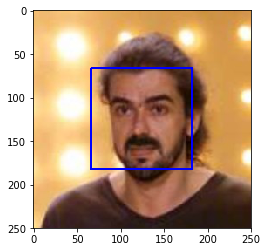

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[8])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

humans = 0
for i in human_files_short:
    if face_detector(i) is True: humans = humans + 1
      
print("The percentage of human faces detected in the first 100 images of human_files is: {}%".format(humans))


dogs = 0
for i in dog_files_short:
    if face_detector(i) is True: dogs = dogs + 1
      
print("The percentage of human faces detected in the first 100 images of dog_files is: {}%".format(dogs))

The percentage of human faces detected in the first 100 images of human_files is: 100%
The percentage of human faces detected in the first 100 images of dog_files is: 11%


In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 3s 0us/step


In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

humans2 = 0
for i in human_files_short:
    if dog_detector(i): humans2 = humans2 + 1
      
print("The percentage of dogs detected in the first 100 images of human_files is: {}%".format(humans2))

dogs2 = 0
for i in dog_files_short:
    if dog_detector(i): dogs2 = dogs2 + 1
      
print("The percentage of dogs detected in the first 100 images of dog_files is: {}%".format(dogs2))

The percentage of dogs detected in the first 100 images of human_files is: 0%
The percentage of dogs detected in the first 100 images of dog_files is: 100%


In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 101.21it/s]


In [12]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [16]:
### TODO: Compile the model.

ResNet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [17]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 25
batch_size = 120

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/25
6680/6680 [==============================] - 1s 109us/step - loss: 2.3559 - acc: 0.4808 - val_loss: 1.2572 - val_acc: 0.6647
Epoch 2/25
6680/6680 [==============================] - 0s 65us/step - loss: 0.7194 - acc: 0.8274 - val_loss: 0.8072 - val_acc: 0.7617
Epoch 3/25
6680/6680 [==============================] - 0s 67us/step - loss: 0.3926 - acc: 0.9060 - val_loss: 0.7046 - val_acc: 0.7844
Epoch 4/25
6680/6680 [==============================] - 0s 68us/step - loss: 0.2472 - acc: 0.9482 - val_loss: 0.6426 - val_acc: 0.7952
Epoch 5/25
6680/6680 [==============================] - 0s 67us/step - loss: 0.1660 - acc: 0.9677 - val_loss: 0.5889 - val_acc: 0.8084
Epoch 6/25
6680/6680 [==============================] - 0s 63us/step - loss: 0.1109 - acc: 0.9814 - val_loss: 0.5899 - val_acc: 0.8144
Epoch 7/25
6680/6680 [==============================] - 0s 67us/step - loss: 0.0762 - acc: 0.9900 - val_loss: 0.5636 - val_acc: 0.8228
Epoch 8

In [18]:
### TODO: Load the model weights with the best validation loss.

ResNet_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

In [19]:
### TODO: Calculate classification accuracy on the test dataset.

ResNet50_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.8182%


In [75]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = ResNet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)][7:50]
    
    y2 = np.argmax(predicted_vector)
    xx = np.argmax(train_targets, axis=1)
    yy= np.where(xx==y2)[0].flat[0]
    
    img2 = cv2.imread(train_files[yy])
    plt.imshow(img2) 
    plt.show()
    
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    
    if dog_detector(img_path) == True:
        return print("This dog is a {}".format(breed))
    else:
        return print("This person resembles a {}".format(breed))

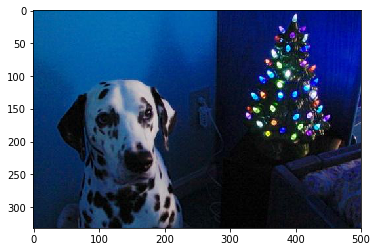

This person resembles a Dalmatian


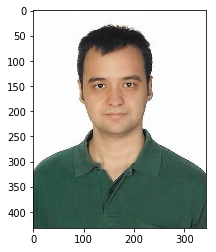

In [76]:
ResNet50_predict_breed('images/foto3.jpg')

This person resembles a Dalmatian


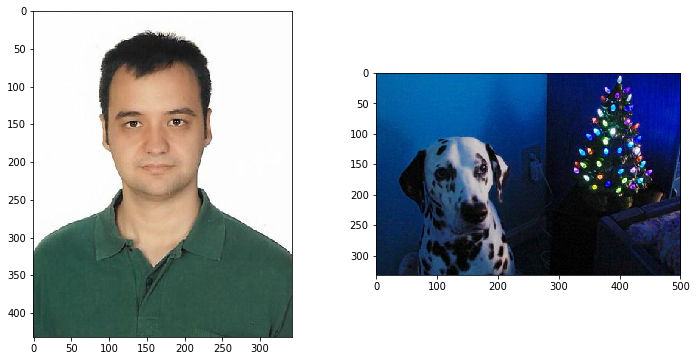

In [90]:

from extract_bottleneck_features import *

def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = ResNet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)][7:50]
    
    y2 = np.argmax(predicted_vector)
    xx = np.argmax(train_targets, axis=1)
    yy= np.where(xx==y2)[0].flat[0]

    img2 = cv2.imread(train_files[yy])
    
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
    axes[0].imshow(cv_rgb)
    axes[1].imshow(img2)

    if dog_detector(img_path) == True: return print("This dog is a {}".format(breed))
    else: return print("This person resembles a {}".format(breed))
    

ResNet50_predict_breed('images/foto3.jpg')
    

In [101]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet_model.add(Dense(133, activation='softmax'))


### TODO: Compile the model.
ResNet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### TODO: Train the model.
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 100
batch_size = 500

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)


### TODO: Load the model weights with the best validation loss.
ResNet_model.load_weights('saved_models/weights.best.ResNet50.hdf5')


### TODO: Calculate classification accuracy on the test dataset.
ResNet50_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - 13s 2ms/step - loss: 4.0419 - acc: 0.1632 - val_loss: 2.5728 - val_acc: 0.4743
Epoch 2/100
6680/6680 [==============================] - 0s 39us/step - loss: 1.7359 - acc: 0.6612 - val_loss: 1.3756 - val_acc: 0.7006
Epoch 3/100
6680/6680 [==============================] - 0s 38us/step - loss: 0.9131 - acc: 0.8180 - val_loss: 0.9961 - val_acc: 0.7473
Epoch 4/100
6680/6680 [==============================] - 0s 38us/step - loss: 0.6105 - acc: 0.8846 - val_loss: 0.8362 - val_acc: 0.7820
Epoch 5/100
6680/6680 [==============================] - 0s 39us/step - loss: 0.4595 - acc: 0.9163 - val_loss: 0.7614 - val_acc: 0.7916
Epoch 6/100
6680/6680 [==============================] - 0s 39us/step - loss: 0.3679 - acc: 0.9434 - val_loss: 0.7045 - val_acc: 0.8144
Epoch 7/100
6680/6680 [==============================] - 0s 38us/step - loss: 0.3021 - acc: 0.9620 - val_loss: 0.6778 - val_acc: 0.8216
E

Epoch 26/100
6680/6680 [==============================] - 0s 38us/step - loss: 0.0458 - acc: 0.9990 - val_loss: 0.5433 - val_acc: 0.8371
Epoch 27/100
6680/6680 [==============================] - 0s 38us/step - loss: 0.0438 - acc: 0.9990 - val_loss: 0.5431 - val_acc: 0.8359
Epoch 28/100
6680/6680 [==============================] - 0s 37us/step - loss: 0.0414 - acc: 0.9990 - val_loss: 0.5416 - val_acc: 0.8311
Epoch 29/100
6680/6680 [==============================] - 0s 32us/step - loss: 0.0390 - acc: 0.9990 - val_loss: 0.5421 - val_acc: 0.8407
Epoch 30/100
6680/6680 [==============================] - 0s 37us/step - loss: 0.0369 - acc: 0.9990 - val_loss: 0.5369 - val_acc: 0.8359
Epoch 31/100
6680/6680 [==============================] - 0s 32us/step - loss: 0.0355 - acc: 0.9990 - val_loss: 0.5406 - val_acc: 0.8371
Epoch 32/100
6680/6680 [==============================] - 0s 33us/step - loss: 0.0339 - acc: 0.9990 - val_loss: 0.5381 - val_acc: 0.8359
Epoch 33/100
6680/6680 [=================

Epoch 57/100
6680/6680 [==============================] - 0s 33us/step - loss: 0.0147 - acc: 0.9988 - val_loss: 0.5417 - val_acc: 0.8395
Epoch 58/100
6680/6680 [==============================] - 0s 34us/step - loss: 0.0140 - acc: 0.9991 - val_loss: 0.5406 - val_acc: 0.8431
Epoch 59/100
6680/6680 [==============================] - 0s 33us/step - loss: 0.0139 - acc: 0.9993 - val_loss: 0.5420 - val_acc: 0.8395
Epoch 60/100
6680/6680 [==============================] - 0s 34us/step - loss: 0.0133 - acc: 0.9990 - val_loss: 0.5429 - val_acc: 0.8419
Epoch 61/100
6680/6680 [==============================] - 0s 33us/step - loss: 0.0129 - acc: 0.9991 - val_loss: 0.5415 - val_acc: 0.8419
Epoch 62/100
6680/6680 [==============================] - 0s 34us/step - loss: 0.0128 - acc: 0.9990 - val_loss: 0.5437 - val_acc: 0.8407
Epoch 63/100
6680/6680 [==============================] - 0s 33us/step - loss: 0.0125 - acc: 0.9991 - val_loss: 0.5435 - val_acc: 0.8431
Epoch 64/100
6680/6680 [=================

6680/6680 [==============================] - 0s 35us/step - loss: 0.0079 - acc: 0.9993 - val_loss: 0.5586 - val_acc: 0.8479
Epoch 90/100
6680/6680 [==============================] - 0s 32us/step - loss: 0.0076 - acc: 0.9988 - val_loss: 0.5523 - val_acc: 0.8443
Epoch 91/100
6680/6680 [==============================] - 0s 33us/step - loss: 0.0077 - acc: 0.9988 - val_loss: 0.5531 - val_acc: 0.8443
Epoch 92/100
6680/6680 [==============================] - 0s 34us/step - loss: 0.0072 - acc: 0.9988 - val_loss: 0.5565 - val_acc: 0.8419
Epoch 93/100
6680/6680 [==============================] - 0s 38us/step - loss: 0.0075 - acc: 0.9988 - val_loss: 0.5562 - val_acc: 0.8443
Epoch 94/100
6680/6680 [==============================] - 0s 35us/step - loss: 0.0078 - acc: 0.9993 - val_loss: 0.5578 - val_acc: 0.8431
Epoch 95/100
6680/6680 [==============================] - 0s 33us/step - loss: 0.0075 - acc: 0.9988 - val_loss: 0.5532 - val_acc: 0.8455
Epoch 96/100
6680/6680 [==============================